# DATA

In [ ]:
# 股票数据
import pandas_datareader.data as web
import datetime
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2024, 1, 1)
df = web.DataReader('GOOGL', 'stooq', start, end)
df.dropna(inplace=True)
df.sort_index(inplace=True)
print(df)

                Open     High       Low     Close    Volume
Date                                                       
2018-01-02   52.6510   53.799   52.6510   53.6720  31753540
2018-01-03   53.6965   54.805   53.6715   54.5760  31305800
2018-01-04   54.8545   55.204   54.7130   54.8000  26049960
2018-01-05   55.1725   55.679   55.0900   55.5145  30238600
2018-01-08   55.5500   55.958   55.5000   55.7105  24626920
...              ...      ...       ...       ...       ...
2023-12-22  140.7700  141.990  140.7100  141.4900  26532199
2023-12-26  141.5900  142.680  141.1900  141.5200  16780333
2023-12-27  141.5900  142.080  139.8860  140.3700  19628618
2023-12-28  140.7800  141.140  139.7500  140.2300  16045712
2023-12-29  139.6300  140.360  138.7800  139.6900  18733017

[1509 rows x 5 columns]


In [ ]:
np.random.normal(0,1,(df.iloc[:,:-2].shape)).shape


(1509, 4)

In [ ]:


mem_his_days=5
per_days=10
# df.dropna(inplace=True)
# df.sort_index(inplace=True)

# 股票数据
df['label'] = df['Close'].shift(-per_days)
# 加入噪声
df_da = df.iloc[:,:-2]
noise = np.random.normal(0, 10, df_da.shape)
df_da += noise



from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
sca_X = scaler.fit_transform(df_da)


from collections import deque
deq = deque(maxlen=mem_his_days)

X = []
for i in sca_X:
    deq.append(list(i))
    if len(deq)==mem_his_days:
        X.append(list(deq))

X_lately = X[-per_days:]
X = X[:-per_days]
y = df['label'].values[mem_his_days-1:-per_days]

import numpy as np
X = np.array(X)
y = np.array(y)

    # return X,y,X_lately

In [ ]:
print(X.shape)
print(y.shape)
print(len(X_lately))

(1495, 5, 4)
(1495,)
10


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(len(X_lately))

(1345, 5, 4)
(1345,)
(150, 5, 4)
(150,)
10


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# 训练数据
batch, length, dim = 64, 5, 4
# noise = np.random.normal(sca_X.mean(), 0.05*sca_X.std(), X_train.shape)
# X_train += noise
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # 确保y_train是二维张量
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# 创建DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True,drop_last=False)

print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([1345, 5, 4])
torch.Size([1345, 1])
torch.Size([150, 5, 4])
torch.Size([150, 1])


# Kamba

In [ ]:
import os
new_dir = "/content"
os.chdir(new_dir)
!rm -r mamba-minimal
!git clone https://github.com/Ykiiii/mamba-minimal.git
new_dir = "/content/mamba-minimal"
os.chdir(new_dir)
!pwd
!pip install einops

Cloning into 'mamba-minimal'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 88 (delta 46), reused 51 (delta 35), pack-reused 24
Receiving objects: 100% (88/88), 899.60 KiB | 26.46 MiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/mamba-minimal


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from model_Lsize_bxn_in_scan import Mamba, ModelArgs,MambaBlock
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 定义模型
class SequenceModel(nn.Module):
    def __init__(self, input_dim, model_dim, state_dim, batch_size, conv_width, expand_factor, output_dim):
        super(SequenceModel, self).__init__()
        args = ModelArgs(d_model=model_dim,n_layer=state_dim,batch_size=batch,
                         d_conv=conv_width,vocab_size=16,expand=expand_factor)
        self.fc1 = nn.Linear(input_dim, model_dim)  # 输入层
        self.mamba = MambaBlock(args)
        self.fc2 = nn.Linear(model_dim*length, output_dim)  # 输出层

    def forward(self, x, loss_mem):
        self.m_in = self.fc1(x)
        self.m_ot = self.mamba(self.m_in, loss_mem)
        self.x0 = self.m_ot.view(self.m_ot.size(0), -1)  # 展平，将 (batch, length, model_dim) 变为 (batch, length * model_dim)
        x = self.fc2(self.x0)
        return x
# 初始化模型
model_kam = SequenceModel(input_dim=dim, model_dim=32, state_dim=16, batch_size=batch,
                      conv_width=4, expand_factor=2, output_dim=1)
print(model_kam)
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model_kam.parameters(), lr=1e-4)
# 动态学习率
# scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.6)
# 定义hook
latest_gradient = torch.zeros(batch,length,64)
def hook_fn(grad):
    global latest_gradient
    latest_gradient = grad

# 训练模型
losses_kam = []
mse_test_kam = []
num_epochs = 10
for epoch in range(num_epochs):
    # 训练
    model_kam.train()
    for x_batch, y_batch in train_loader:
        y_pred = model_kam(x_batch,latest_gradient)
        loss = criterion(y_pred, y_batch)

        hook_handle = model_kam.mamba.intermediate_output.register_hook(hook_fn)
        grad_mem = latest_gradient[:,2]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses_kam.append(loss.item())
    # 评价
    model_kam.eval()
    y_pred = torch.randn((1,1))
    with torch.no_grad():
        a = 0
        for i in range(X_test_tensor.shape[0]//batch):
            y_pred_batch = model_kam(X_test_tensor[i*batch:(i+1)*batch],latest_gradient)
            y_pred = torch.cat((y_pred,y_pred_batch),dim=0)
        y_pred_batch = model_kam(torch.cat((X_test_tensor[(i+1)*batch:],X_test_tensor[:batch-X_test_tensor.shape[0]%batch]),dim=0),latest_gradient)
        y_pred = torch.cat((y_pred,y_pred_batch),dim=0)
    # print(f"Predicted shape: {y_pred.shape}")
    # y_pred = torch.cat((y_pred1,y_pred2,y_pred3),dim=0)[:150]
    mse = mean_squared_error(y_pred[1:X_test_tensor.shape[0]+1] , y_test_tensor)
    mse_test_kam.append(mse)

    hook_handle.remove()
    # 打印
    if (epoch + 1) % 5 == 0:
        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, \t Mse:{mse:.4f}')


# 清除GPU缓存
if torch.cuda.is_available():
    torch.cuda.empty_cache()

SequenceModel(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (mamba): MambaBlock(
    (in_proj): Linear(in_features=32, out_features=128, bias=False)
    (conv1d): Conv1d(64, 64, kernel_size=(4,), stride=(1,), padding=(3,), groups=64)
    (x_proj): Linear(in_features=64, out_features=34, bias=False)
    (dt_proj): Linear(in_features=2, out_features=64, bias=True)
    (out_proj): Linear(in_features=64, out_features=32, bias=False)
  )
  (fc2): Linear(in_features=160, out_features=1, bias=True)
)
Predicted shape: torch.Size([193, 1])
Predicted shape: torch.Size([193, 1])
Predicted shape: torch.Size([193, 1])
Predicted shape: torch.Size([193, 1])
Predicted shape: torch.Size([193, 1])
Epoch [5/10], Loss: 3726.6917, 	 Mse:9716.1572
Predicted shape: torch.Size([193, 1])
Predicted shape: torch.Size([193, 1])
Predicted shape: torch.Size([193, 1])
Predicted shape: torch.Size([193, 1])
Predicted shape: torch.Size([193, 1])
Epoch [10/10], Loss: 3411.9126, 	 Mse:6367.7910


In [ ]:
# 绘制 loss 曲线
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
# 训练数据
x = np.linspace(1,num_epochs,num_epochs)
y = np.array(losses_kam)
fig, ax = plt.subplots(figsize=(8, 5))
# 主图
plt.plot(x,y, label='Training loss')
ax.grid(True, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
# 子图
inset_ax = inset_axes(ax, width="45%", height="45%", loc='upper right',
                      bbox_to_anchor=(0.1, 0.1, 0.8, 0.7), bbox_transform=ax.transAxes)
inset_ax.plot(x, y)
inset_ax.set_xlim(40, 80)  # 设置X轴范围
inset_ax.set_ylim(0, 150)  # 设置Y轴范围
inset_ax.grid(True, linestyle='--')
# 连接线
mark_inset(ax, inset_ax, loc1=2, loc2=4, fc="none", ec="0.5",linestyle="--")
plt.show()

# 测试数据
# x = np.linspace(1,num_epochs)
y = np.array(mse_test_kam)
fig, ax = plt.subplots(figsize=(8, 5))
# 主图
plt.plot(x,y, label='Testing loss')
ax.grid(True, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Testing Loss over Epochs')
plt.legend()
# 子图
inset_ax = inset_axes(ax, width="45%", height="45%", loc='upper right',
                      bbox_to_anchor=(0.1, 0.1, 0.8, 0.7), bbox_transform=ax.transAxes)
inset_ax.plot(x, y)
inset_ax.set_xlim(40, 80)  # 设置X轴范围
inset_ax.set_ylim(0, 100)  # 设置Y轴范围
inset_ax.grid(True, linestyle='--')
# 连接线
mark_inset(ax, inset_ax, loc1=2, loc2=4, fc="none", ec="0.5",linestyle="--")


plt.show()

## 实验

In [1]:
import os
new_dir = "/content"
os.chdir(new_dir)
!rm -r mamba-minimal
!git clone https://github.com/Ykiiii/mamba-minimal.git
new_dir = "/content/mamba-minimal"
os.chdir(new_dir)
!pwd
!pip install einops

Cloning into 'mamba-minimal'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 141 (delta 89), reused 79 (delta 54), pack-reused 24
Receiving objects: 100% (141/141), 918.54 KiB | 4.76 MiB/s, done.
Resolving deltas: 100% (89/89), done.
/content/mamba-minimal


In [1]:
# 股票数据
import pandas_datareader.data as web
import datetime
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2024, 1, 1)
df = web.DataReader('GOOGL', 'stooq', start, end)
df.dropna(inplace=True)
df.sort_index(inplace=True)
print(df)

                Open      High       Low     Close     Volume
Date                                                         
2014-01-02   27.8865   27.9440   27.7065   27.8280   72904600
2014-01-03   27.8750   27.9230   27.6230   27.6250   66708480
2014-01-06   27.8000   27.9715   27.6610   27.9330   70818120
2014-01-07   28.1250   28.4920   28.0290   28.4715  102144520
2014-01-08   28.6500   28.6830   28.3320   28.5310   89706880
...              ...       ...       ...       ...        ...
2023-12-22  140.7700  141.9900  140.7100  141.4900   26532199
2023-12-26  141.5900  142.6800  141.1900  141.5200   16780333
2023-12-27  141.5900  142.0800  139.8860  140.3700   19628618
2023-12-28  140.7800  141.1400  139.7500  140.2300   16045712
2023-12-29  139.6300  140.3600  138.7800  139.6900   18733017

[2516 rows x 5 columns]


##    noise

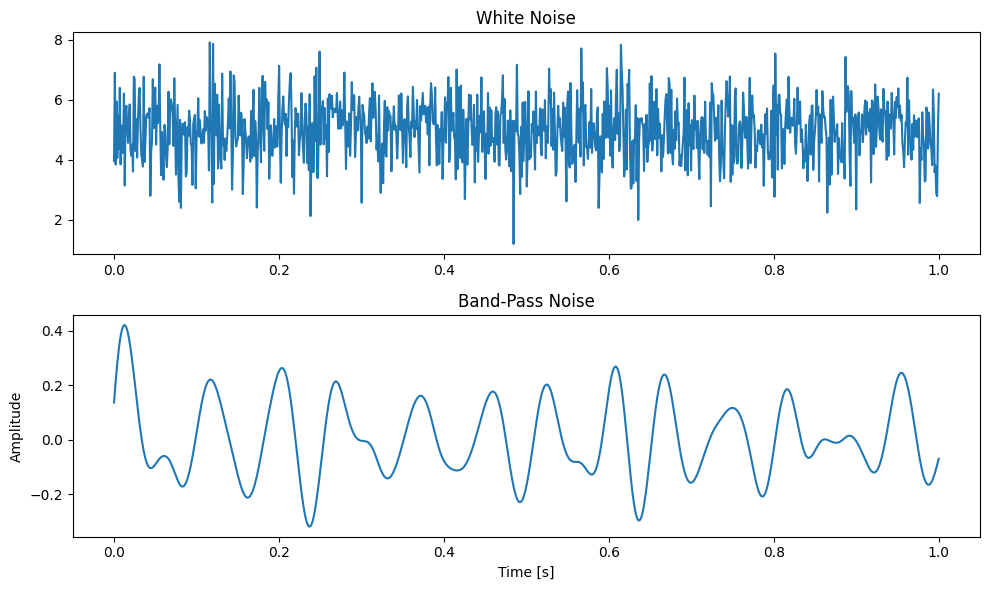

In [ ]:
import numpy as np
from scipy.signal import butter, filtfilt

# 参数设置
fs = 1000  # 采样频率（Hz）
t = np.linspace(0, 1, fs)  # 时间向量，假设信号长度为1秒

# 带通滤波器的参数
f_low = 10  # 低截止频率（Hz）
f_high = 20  # 高截止频率（Hz）

# 计算归一化截止频率
Wn = [f_low/(fs/2), f_high/(fs/2)]

# 设计带通滤波器
b, a = butter(N=2, Wn=Wn, btype='bandpass')

# 生成白噪声
noise = np.random.randn(fs)+5
# noise = np.random.normal(50,10,(1000))

# 应用带通滤波器
band_pass_noise = filtfilt(b, a, noise)

# 绘制结果
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.title('White Noise')
plt.plot(t, noise)

plt.subplot(2, 1, 2)
plt.title('Band-Pass Noise')
plt.plot(t, band_pass_noise)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

<ipython-input-29-8f926423f410>:49: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
<ipython-input-29-8f926423f410>:49: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
<ipython-input-29-8f926423f410>:49: UserWarning: Glyph 25391 (\N{CJK UNIFIED IDEOGRAPH-632F}) missing from current font.
  plt.tight_layout()
<ipython-input-29-8f926423f410>:49: UserWarning: Glyph 24133 (\N{CJK UNIFIED IDEOGRAPH-5E45}) missing from current font.
  plt.tight_layout()
<ipython-input-29-8f926423f410>:49: UserWarning: Glyph 32431 (\N{CJK UNIFIED IDEOGRAPH-7EAF}) missing from current font.
  plt.tight_layout()
<ipython-input-29-8f926423f410>:49: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from current font.
  plt.tight_layout()
<ipython-input-29-8f926423f410>:49: UserWarning: Glyph 24358 (\N{CJK UNIFIED IDEOGRAPH-5F26}) missing from current font.
  plt.tight_layout()
<ipyth

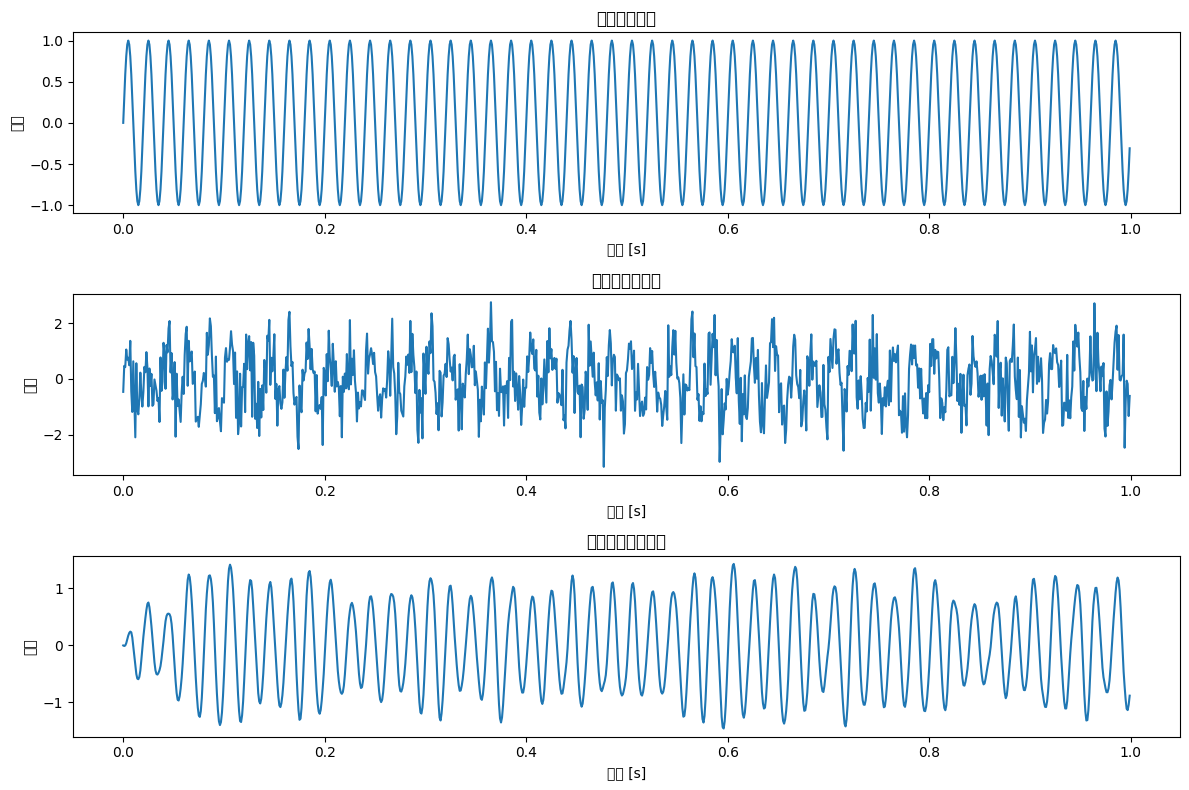

In [ ]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# 设置参数
fs = 1000  # 采样频率 (Hz)
t = np.arange(0, 1.0, 1.0/fs)  # 时间向量
f0 = 50  # 信号频率 (Hz)
noise_power = 0.001 * fs / 2  # 噪声功率

# 生成正弦波信号
pure_signal = np.sin(2 * np.pi * f0 * t)

# 添加白噪声
noisy_signal = pure_signal + np.random.normal(scale=np.sqrt(noise_power), size=t.shape)

# 定义带通滤波器
lowcut = 30.0
highcut = 70.0
nyq = 0.5 * fs
low = lowcut / nyq
high = highcut / nyq
b, a = signal.butter(2, [low, high], btype='band')

# 应用带通滤波器
filtered_signal = signal.lfilter(b, a, noisy_signal)

# 绘制信号
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, pure_signal)
plt.title('纯正弦波信号')
plt.xlabel('时间 [s]')
plt.ylabel('振幅')

plt.subplot(3, 1, 2)
plt.plot(t, noisy_signal)
plt.title('带白噪声的信号')
plt.xlabel('时间 [s]')
plt.ylabel('振幅')

plt.subplot(3, 1, 3)
plt.plot(t, filtered_signal)
plt.title('带通滤波后的信号')
plt.xlabel('时间 [s]')
plt.ylabel('振幅')

plt.tight_layout()
plt.show()


## 改进

In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# 训练数据
batch, length, dim = 64, 5, 4
# noise = np.random.normal(sca_X.mean(), 0.05*sca_X.std(), X_train.shape)
# X_train += noise
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # 确保y_train是二维张量
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# # 虚拟数据
X_train_tensor = torch.randn(1351,5,4)
y_train_tensor = torch.randn(1351,1)
X_test_tensor = torch.randn(150,5,4)
y_test_tensor = torch.randn(150,1)

# 定义训练集数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True,drop_last=False)

# 定义测试集数据加载器
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False)

print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)

e:\program\anaconda3\envs\yk_lstm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1351, 5, 4])
torch.Size([1351, 1])
torch.Size([150, 5, 4])
torch.Size([150, 1])


In [6]:
# 形式改进
# mam训练测试
import gc,time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
# from model_deltaLsize_bxn_in_scan import Mamba, ModelArgs,MambaBlock # 原始mam，引用谁都行
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from dataclasses import dataclass


def mam_experiments(train_loader,test_loader,num_epochs=10):
  print("mam training:")
  from model_deltaLsize_bxn_in_scan import Mamba, ModelArgs,MambaBlock # 原始mam，引用谁都行
  # 定义模型################################################################
  class SequenceModel(nn.Module):
      def __init__(self, input_dim, model_dim, state_dim, 
                   batch_size, conv_width, expand_factor, output_dim):
          super(SequenceModel, self).__init__()
          args = ModelArgs(d_model=model_dim,n_layer=state_dim,batch_size=batch,
                          d_conv=conv_width,vocab_size=16,expand=expand_factor)
          self.fc1 = nn.Linear(input_dim, model_dim)  # 输入层
          self.mamba = MambaBlock(args)
          self.fc2 = nn.Linear(model_dim*length, output_dim)  # 输出层

      def forward(self, x):
          x = self.fc1(x)
          x = self.mamba(x)
          x = x.view(x.size(0), -1)  # 展平，将 (batch, length, model_dim) 变为 (batch, length * model_dim)
          x = self.fc2(x)
          return x
  ##########################################################################
  # 初始化模型
  model_mam = SequenceModel(input_dim=dim, model_dim=32, state_dim=16, batch_size=batch,
                            conv_width=4, expand_factor=2, output_dim=1)
  # print(model_mam)
  # 定义损失函数和优化器
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model_mam.parameters(), lr=1e-4)
  # 动态学习率
  # scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.6)
  # 训练模型
  losses_mam = []
  mse_test_mam = []
  start_time = time.time()
  epoch_time = 0
  # num_epochs = 10######################################################
  for epoch in range(num_epochs):
      # 训练
      model_mam.train()
      for x_batch, y_batch in train_loader:
          # print(x_batch.shape,y_batch.shape)
          y_pred = model_mam(x_batch)
          loss = criterion(y_pred, y_batch)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      losses_mam.append(loss.item())
      # 评价
      model_mam.eval()
      y_pred_list = []
      y_test_list = []
      for x_test_batch,y_test_batch in test_loader:
          y_test_list.append(y_test_batch)
          with torch.no_grad():
              y_pred_batch = model_mam(x_test_batch)
              y_pred_list.append(y_pred_batch)
      y_pred_lists = torch.cat(tuple(y_pred_list),dim=0)
      y_test_lists = torch.cat(tuple(y_test_list),dim=0)
      mse = mean_squared_error(y_pred_lists , y_test_lists)
      mse_test_mam.append(mse)

      # 打印
      if (epoch + 1) % 5 == 0:
          elapsed_time = time.time() - start_time
          epoch_time = elapsed_time - epoch_time
          total_time = elapsed_time+(num_epochs-epoch-1)*(epoch_time/5)
          epoch_time = elapsed_time
          print(f'mam_Epoch [{epoch+1}/{num_epochs}],\tLoss: {loss.item():.4f},',end='')
          print(f'\tMse: {mse:.4f}, \tTime: {elapsed_time:.2f}s/{total_time:.2f}s')

  # 清除模型 #############################################################
  del model_mam
  gc.collect()
  # 清除GPU缓存
  if torch.cuda.is_available():
      torch.cuda.empty_cache()

  return losses_mam,mse_test_mam

losses_mam,mse_test_mam = mam_experiments(train_loader,test_loader,num_epochs=10)

NameError: name 'Union' is not defined

## data

In [35]:
# 制作数据集
from sklearn.preprocessing import StandardScaler
from collections import deque
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

# # 检查CUDA是否可用
# if torch.cuda.is_available():
#     device = torch.device("cuda")
# else:
#     device = torch.device("cpu")

def make_data(df=df,noise_mean=0,noise_std=10):
  mem_his_days=5
  per_days=10
  # y 股票数据
  df['label'] = df['Close'].shift(-per_days)
  # x 加入噪声
  df_da = df.iloc[:,:-2]
  print("原始数据：")
  print(df_da.describe().iloc[[1,2],:])

  # 高斯噪声
  noise = np.random.normal(noise_mean, noise_std, df_da.shape)
  # # 正弦噪声
  # frequency = 10  # 频率，例如5Hz
  # time = np.linspace(0, df_da.shape[0], df_da.shape[0])  # 生成数据数量
  # phase = np.pi / 4  # 相位，例如π/4
  # amplitude = 10  # 振幅
  # sin_wave = amplitude * np.sin(2 * np.pi * frequency * time + phase)
  # noise_sin = np.expand_dims(sin_wave, axis=1)
  # noise_sin = noise_sin.repeat(df_da.shape[1],axis=1)
  # noise = noise_sin + np.random.normal(noise_mean, noise_std, df_da.shape)
  # # 线性噪声
  # time = np.linspace(0, df_da.shape[0], df_da.shape[0])  # 生成数据数量
  # noise_line = time*0.05
  # noise_line = np.expand_dims(noise_line, axis=1)
  # noise_line = noise_line.repeat(df_da.shape[1],axis=1)
  # noise = noise_line + noise

  # # 加性噪声
  # df_da += noise

  # 乘性噪声
  df_da *= noise

  print("噪声数据：")
  print(df_da.describe().iloc[[1,2],:])
  # 缩放
  scaler = StandardScaler()
  sca_X = scaler.fit_transform(df_da)
  # x 队列
  deq = deque(maxlen=mem_his_days)
  X = []
  for i in sca_X:
      deq.append(list(i))
      if len(deq)==mem_his_days:
          X.append(list(deq))
  X_lately = X[-per_days:]
  X = X[:-per_days]
  y = df['label'].values[mem_his_days-1:-per_days]
  # array
  X = np.array(X)
  y = np.array(y)
  # 拆分训练测试
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)
  # 训练数据
  global batch, length, dim
  batch, length, dim = 64, X_test.shape[1], X_test.shape[2]
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # 确保y_train是二维张量
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
  y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
  # 定义训练集数据加载器
  train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
  train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True,drop_last=False)
  # 定义测试集数据加载器
  test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
  test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False)
  # print(X_train_tensor.shape)
  # print(y_train_tensor.shape)
  # print(X_test_tensor.shape)
  # print(y_test_tensor.shape)
  return train_loader,test_loader,X_test_tensor,y_test_tensor

# train_loader,test_loader,X_test_tensor,y_test_tensor = make_data(df=df,noise_std=20)
# print(X_test_tensor.shape)
# print(y_test_tensor.shape)

## mam
x(k+1)=delta A * x(k) + delta B * u(k)

In [36]:
# mam训练测试
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from model_deltaLsize_bxn_in_scan import Mamba, ModelArgs,MambaBlock # 原始mam，引用谁都行
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def mam_experiments(train_loader,test_loader,X_test_tensor,y_test_tensor,num_epochs=10):
  print("mam training:")
  # 定义模型
  class SequenceModel(nn.Module):
      def __init__(self, input_dim, model_dim, state_dim, batch_size, conv_width, expand_factor, output_dim):
          super(SequenceModel, self).__init__()
          args = ModelArgs(d_model=model_dim,n_layer=state_dim,batch_size=batch,
                          d_conv=conv_width,vocab_size=16,expand=expand_factor)
          self.fc1 = nn.Linear(input_dim, model_dim)  # 输入层
          self.mamba = MambaBlock(args)
          self.fc2 = nn.Linear(model_dim*length, output_dim)  # 输出层

      def forward(self, x):
          x = self.fc1(x)
          x = self.mamba(x)
          x = x.view(x.size(0), -1)  # 展平，将 (batch, length, model_dim) 变为 (batch, length * model_dim)
          x = self.fc2(x)
          return x

  # 初始化模型
  model_mam = SequenceModel(input_dim=dim, model_dim=32, state_dim=16, batch_size=batch,
                            conv_width=4, expand_factor=2, output_dim=1)
  # print(model_mam)
  # 定义损失函数和优化器
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model_mam.parameters(), lr=1e-4)
  # 动态学习率
  # scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.6)
  # 训练模型
  losses_mam = []
  mse_test_mam = []
  # num_epochs = 10
  for epoch in range(num_epochs):
      # 训练
      model_mam.train()
      for x_batch, y_batch in train_loader:
          # print(x_batch.shape,y_batch.shape)
          y_pred = model_mam(x_batch)
          loss = criterion(y_pred, y_batch)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      losses_mam.append(loss.item())
      # 评价
      model_mam.eval()
      y_pred = []
      for x_test_batch,y_test_batch in test_loader:
          with torch.no_grad():
              y_pred_batch = model_mam(x_test_batch)
              y_pred.append(y_pred_batch)
      y_pred = torch.cat(tuple(y_pred),dim=0)
      mse = mean_squared_error(y_pred , y_test_tensor)
      mse_test_mam.append(mse)

      # 打印
      if (epoch + 1) % 5 == 0:
          print(f'mam_Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, \t Mse:{mse:.4f}')
    # 清除GPU缓存
  if torch.cuda.is_available():
      torch.cuda.empty_cache()

  return losses_mam,mse_test_mam

# losses_mam,mse_test_mam = mam_experiments(train_loader,test_loader,X_test_tensor,y_test_tensor,num_epochs=10)

## kam_L*grad(k-1)
x(k+1)=deltaA*x(k)+deltaB*u(k)+L*grad(k-1)

In [4]:
# kam训练测试
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from model_Lsize_bxn_in_scan import Mamba, ModelArgs,MambaBlock
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def kam_L_gradk_sub_1_expt(train_loader,test_loader,X_test_tensor,y_test_tensor,num_epochs=10):
  print("kam training:")
  # 定义模型
  class SequenceModel(nn.Module):
      def __init__(self, input_dim, model_dim, state_dim, batch_size, conv_width, expand_factor, output_dim):
          super(SequenceModel, self).__init__()
          args = ModelArgs(d_model=model_dim,n_layer=state_dim,batch_size=batch,
                          d_conv=conv_width,vocab_size=16,expand=expand_factor)
          self.fc1 = nn.Linear(input_dim, model_dim)  # 输入层
          self.mamba = MambaBlock(args)
          self.fc2 = nn.Linear(model_dim*length, output_dim)  # 输出层

      def forward(self, x, loss_mem):
          self.m_in = self.fc1(x)
          self.m_ot = self.mamba(self.m_in, loss_mem)
          self.x0 = self.m_ot.view(self.m_ot.size(0), -1)  # 展平，将 (batch, length, model_dim) 变为 (batch, length * model_dim)
          x = self.fc2(self.x0)
          return x
  # 初始化模型
  model_kam = SequenceModel(input_dim=dim, model_dim=32, state_dim=16, batch_size=batch,
                        conv_width=4, expand_factor=2, output_dim=1)
  # print(model_kam)
  # 定义损失函数和优化器
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model_kam.parameters(), lr=1e-4)
  # 动态学习率
  # scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.6)
  # 定义hook
  latest_gradient = torch.zeros(batch,length,64)
  def hook_fn(grad):
      global latest_gradient
      latest_gradient = grad if grad.shape[0]==batch else latest_gradient

  # 训练模型
  losses_kam = []
  mse_test_kam = []
  # num_epochs = 10
  for epoch in range(num_epochs):
      # 训练
      model_kam.train()
      for x_batch, y_batch in train_loader:
          y_pred = model_kam(x_batch,latest_gradient)
          loss = criterion(y_pred, y_batch)

          hook_handle = model_kam.mamba.intermediate_output.register_hook(hook_fn)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      losses_kam.append(loss.item())
      # 评价
      model_kam.eval()
      y_pred = []
      for x_test_batch,y_test_batch in test_loader:
          with torch.no_grad():
              y_pred_batch = model_kam(x_test_batch,latest_gradient)
              y_pred.append(y_pred_batch)
      y_pred = torch.cat(tuple(y_pred),dim=0)
      mse = mean_squared_error(y_pred , y_test_tensor)
      mse_test_kam.append(mse)

      hook_handle.remove()
      # 打印
      if (epoch + 1) % 5 == 0:
          # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
          print(f'kam_Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, \t Mse:{mse:.4f}')

  # 清除GPU缓存
  if torch.cuda.is_available():
      torch.cuda.empty_cache()

  return losses_kam,mse_test_kam

# losses_kam,mse_test_kam = kam_L_gradk_sub_1_expt(train_loader,test_loader,X_test_tensor,y_test_tensor,num_epochs=10)

## kam_deltaL*grad(k-1)
x(k+1)=deltaA*x(k)+deltaB*u(k)+deltaL*grad(k-1)

In [37]:
# kam训练测试
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from model_deltaLsize_bxn_in_scan import Mamba, ModelArgs,MambaBlock
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def kam_deltaL_gradk_sub_1_expt(train_loader,test_loader,X_test_tensor,y_test_tensor,num_epochs=10):
  print("kam training:")
  # 定义模型
  class SequenceModel(nn.Module):
      def __init__(self, input_dim, model_dim, state_dim, batch_size, conv_width, expand_factor, output_dim):
          super(SequenceModel, self).__init__()
          args = ModelArgs(d_model=model_dim,n_layer=state_dim,batch_size=batch,
                          d_conv=conv_width,vocab_size=16,expand=expand_factor)
          self.fc1 = nn.Linear(input_dim, model_dim)  # 输入层
          self.mamba = MambaBlock(args)
          self.fc2 = nn.Linear(model_dim*length, output_dim)  # 输出层

      def forward(self, x, loss_mem):
          self.m_in = self.fc1(x)
          self.m_ot = self.mamba(self.m_in, loss_mem)
          self.x0 = self.m_ot.view(self.m_ot.size(0), -1)  # 展平，将 (batch, length, model_dim) 变为 (batch, length * model_dim)
          x = self.fc2(self.x0)
          return x
  # 初始化模型
  model_kam = SequenceModel(input_dim=dim, model_dim=32, state_dim=16, batch_size=batch,
                        conv_width=4, expand_factor=2, output_dim=1)
  # print(model_kam)
  # 定义损失函数和优化器
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model_kam.parameters(), lr=1e-4)
  # 动态学习率
  # scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.6)
  # 定义hook
  latest_gradient = torch.zeros(batch,length,64)
  def hook_fn(grad):
      global latest_gradient
      latest_gradient = grad if grad.shape[0]==batch else latest_gradient

  # 训练模型
  losses_kam = []
  mse_test_kam = []
  # num_epochs = 10
  for epoch in range(num_epochs):
      # 训练
      model_kam.train()
      for x_batch, y_batch in train_loader:
          y_pred = model_kam(x_batch,latest_gradient)
          loss = criterion(y_pred, y_batch)

          hook_handle = model_kam.mamba.intermediate_output.register_hook(hook_fn)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      losses_kam.append(loss.item())
      # 评价
      model_kam.eval()
      y_pred = []
      for x_test_batch,y_test_batch in test_loader:
          with torch.no_grad():
              y_pred_batch = model_kam(x_test_batch,latest_gradient)
              y_pred.append(y_pred_batch)
      y_pred = torch.cat(tuple(y_pred),dim=0)
      mse = mean_squared_error(y_pred , y_test_tensor)
      mse_test_kam.append(mse)

      hook_handle.remove()
      # 打印
      if (epoch + 1) % 5 == 0:
          # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
          print(f'kam_Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, \t Mse:{mse:.4f}')

  # 清除GPU缓存
  if torch.cuda.is_available():
      torch.cuda.empty_cache()

  return losses_kam,mse_test_kam

# losses_kam,mse_test_kam = kam_deltaL_gradk_sub_1_expt(train_loader,test_loader,X_test_tensor,y_test_tensor,num_epochs=10)

## kam_deltaL*grad(k)
x(k+1)=deltaA*x(k)+deltaB*u(k)+deltaL*grad(k)

In [51]:
# kam训练测试
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from model_deltaLsize_bxn_in_scan import Mamba, ModelArgs,MambaBlock
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def kam_deltaL_gradk_expt(train_loader,test_loader,X_test_tensor,y_test_tensor,num_epochs=10):
  print("kam training:")
  # 定义模型
  class SequenceModel(nn.Module):
      def __init__(self, input_dim, model_dim, state_dim, batch_size, conv_width, expand_factor, output_dim):
          super(SequenceModel, self).__init__()
          args = ModelArgs(d_model=model_dim,n_layer=state_dim,batch_size=batch,
                          d_conv=conv_width,vocab_size=16,expand=expand_factor)
          self.fc1 = nn.Linear(input_dim, model_dim)  # 输入层
          self.mamba = MambaBlock(args)
          self.fc2 = nn.Linear(model_dim*length, output_dim)  # 输出层

      def forward(self, x, loss_mem=None):
          self.m_in = self.fc1(x)
          self.m_ot = self.mamba(self.m_in, loss_mem)
          self.x0 = self.m_ot.view(self.m_ot.size(0), -1)  # 展平，将 (batch, length, model_dim) 变为 (batch, length * model_dim)
          x = self.fc2(self.x0)
          return x
  # 初始化模型
  model_kam = SequenceModel(input_dim=dim, model_dim=32, state_dim=16, batch_size=batch,
                        conv_width=4, expand_factor=2, output_dim=1)
  # print(model_kam)
  # 定义损失函数和优化器
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model_kam.parameters(), lr=1e-4)
  # 动态学习率
  # scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.6)
  # 定义hook
  latest_gradient = torch.zeros(batch,length,64)
  def hook_fn(grad):
      global latest_gradient
      latest_gradient = grad if grad.shape[0]==batch else latest_gradient

  # 训练模型
  losses_kam = []
  mse_test_kam = []
  # num_epochs = 10
  for epoch in range(num_epochs):
      # 训练
      model_kam.train()
      for x_batch, y_batch in train_loader:
          y_pred = model_kam(x_batch)
          loss = criterion(y_pred, y_batch)
          hook_handle = model_kam.mamba.intermediate_output.register_hook(hook_fn)
          y_pred = model_kam(x_batch,latest_gradient)
          loss = criterion(y_pred, y_batch)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      losses_kam.append(loss.item())
      # 评价
      model_kam.eval()
      y_pred = []
      for x_test_batch,y_test_batch in test_loader:
          x_test_batch.requires_grad = True
          y_pred_batch = model_kam(x_test_batch)
          loss = criterion(y_pred_batch, y_test_batch)
          # hook_handle = model_kam.mamba.intermediate_output.register_hook(hook_fn)
          optimizer.zero_grad()
          loss.backward()
          with torch.no_grad():
              y_pred_batch = model_kam(x_test_batch,latest_gradient)
              y_pred.append(y_pred_batch)
      y_pred = torch.cat(tuple(y_pred),dim=0)
      mse = mean_squared_error(y_pred , y_test_tensor)
      mse_test_kam.append(mse)

      hook_handle.remove()
      # 打印
      if (epoch + 1) % 5 == 0:
          # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
          print(f'kam_Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, \t Mse:{mse:.4f}')

  # 清除GPU缓存
  if torch.cuda.is_available():
      torch.cuda.empty_cache()

  return losses_kam,mse_test_kam

# losses_kam,mse_test_kam = kam_deltaL_gradk_expt(train_loader,test_loader,X_test_tensor,y_test_tensor,num_epochs=10)

## main

In [59]:
# main
print("---------Load--------")
train_loader,test_loader,X_test_tensor,y_test_tensor = make_data(df=df,noise_mean=1.2,noise_std=0.5)
print("-------training------")
num_epochs=1000
losses_mam,mse_test_mam = mam_experiments(train_loader,test_loader,X_test_tensor,y_test_tensor,num_epochs=num_epochs)
# losses_kam,mse_test_kam = kam_L_gradk_sub_1_expt(train_loader,test_loader,X_test_tensor,y_test_tensor,num_epochs=num_epochs)
# losses_kam,mse_test_kam = kam_deltaL_gradk_sub_1_expt(train_loader,test_loader,X_test_tensor,y_test_tensor,num_epochs=num_epochs)
losses_kam,mse_test_kam = kam_deltaL_gradk_expt(train_loader,test_loader,X_test_tensor,y_test_tensor,num_epochs=num_epochs)

---------Load--------
原始数据：
           Open       High        Low      Close
mean  69.127314  69.857018  68.411320  69.152336
std   36.614974  37.058992  36.199894  36.633914
噪声数据：
           Open       High        Low      Close
mean  82.951888  82.405280  81.635893  82.639995
std   58.626157  59.037018  58.806549  57.880442
-------training------
mam training:
mam_Epoch [5/1000], Loss: 2684.8074, 	 Mse:3730.5632
mam_Epoch [10/1000], Loss: 2625.3098, 	 Mse:2971.8352
mam_Epoch [15/1000], Loss: 2899.6001, 	 Mse:2191.6118
mam_Epoch [20/1000], Loss: 1899.1344, 	 Mse:1551.8000
mam_Epoch [25/1000], Loss: 937.0344, 	 Mse:764.9946
mam_Epoch [30/1000], Loss: 121.1420, 	 Mse:114.9690
mam_Epoch [35/1000], Loss: 57.8251, 	 Mse:66.1435
mam_Epoch [40/1000], Loss: 51.9314, 	 Mse:54.4578
mam_Epoch [45/1000], Loss: 63.5948, 	 Mse:50.0894
mam_Epoch [50/1000], Loss: 33.5505, 	 Mse:48.1520
mam_Epoch [55/1000], Loss: 37.5704, 	 Mse:47.0152
mam_Epoch [60/1000], Loss: 24.2609, 	 Mse:46.6471
mam_Epoch [65/100

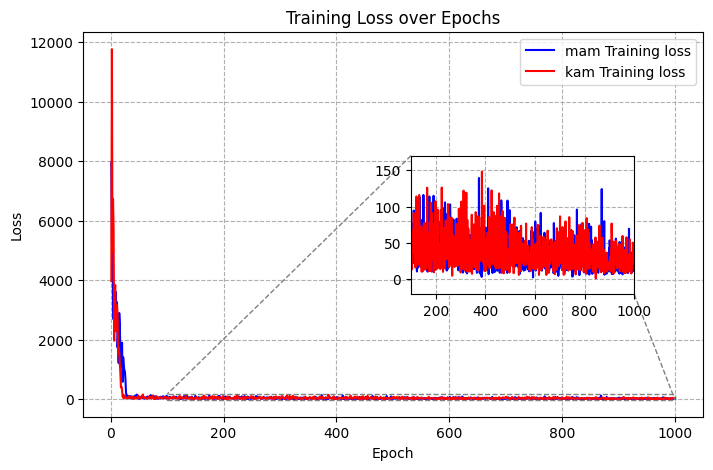

In [60]:
## 训练数据
# 绘制 loss 曲线
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
# 训练数据
x = np.linspace(1,num_epochs,num_epochs)
y_m = np.array(losses_mam)
y_k = np.array(losses_kam)
fig, ax = plt.subplots(figsize=(8, 5))
# 主图
plt.plot(x,y_m,color='blue', label='mam Training loss')
plt.plot(x,y_k,color='red', label='kam Training loss')
ax.grid(True, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# 子图
inset_ax = inset_axes(ax, width="45%", height="45%", loc='lower right',
                      bbox_to_anchor=(0.1, 0.3, 0.8, 0.8), bbox_transform=ax.transAxes)
inset_ax.plot(x, y_m, color='blue')
inset_ax.plot(x, y_k, color='red')
x1,x2 = 100, num_epochs# 设置X轴获取范围
ymax = max(y_m[x1:x2].max(),y_k[x1:x2].max())
ymin = min(y_m[x1:x2].min(),y_k[x1:x2].min())
inset_ax.set_xlim(x1, x2)  # 设置X轴范围
inset_ax.set_ylim(ymin-(ymax-ymin)*0.15, ymax+(ymax-ymin)*0.15)  # 设置Y轴范围
inset_ax.grid(True, linestyle='--')
# 连接线
mark_inset(ax, inset_ax, loc1=2, loc2=4, fc="none", ec="0.5",linestyle="--")

plt.show()

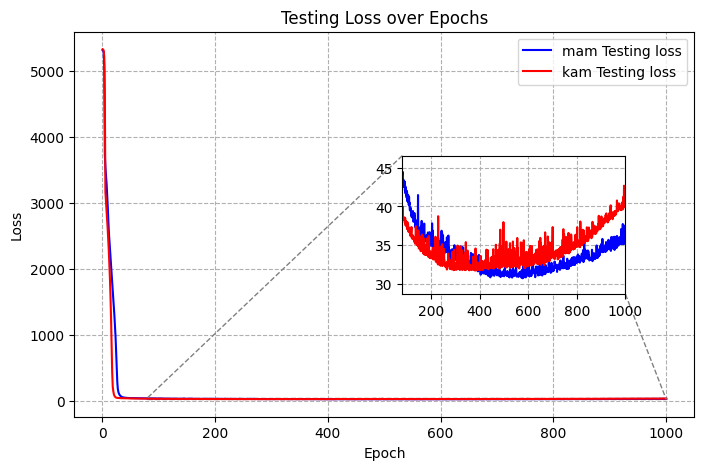

In [61]:
# # 测试数据
# 绘制 loss 曲线
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
# num_epochs = 1000
x = np.linspace(1,num_epochs,num_epochs)
y_m = np.array(mse_test_mam)[:num_epochs]
y_k = np.array(mse_test_kam)[:num_epochs]
fig, ax = plt.subplots(figsize=(8, 5))
# 主图
plt.plot(x,y_m,color='blue', label='mam Testing loss')
plt.plot(x,y_k,color='red', label='kam Testing loss')
ax.grid(True, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Testing Loss over Epochs')
plt.legend()

# 子图
inset_ax = inset_axes(ax, width="45%", height="45%", loc='lower right',
                      bbox_to_anchor=(0.1, 0.3, 0.8, 0.8), bbox_transform=ax.transAxes)
inset_ax.plot(x, y_m, color='blue')
inset_ax.plot(x, y_k, color='red')
x1,x2 = 80, num_epochs  # 设置X轴获取范围
# x1,x2 = 600,1000 # 设置X轴获取范围
ymax = max(y_m[x1:x2].max(),y_k[x1:x2].max())
ymin = min(y_m[x1:x2].min(),y_k[x1:x2].min())
inset_ax.set_xlim(x1, x2)  # 设置X轴范围
inset_ax.set_ylim(ymin-(ymax-ymin)*0.15, ymax+(ymax-ymin)*0.15)  # 设置Y轴范围
inset_ax.grid(True, linestyle='--')
# 连接线
mark_inset(ax, inset_ax, loc1=2, loc2=4, fc="none", ec="0.5",linestyle="--")

plt.show()

In [48]:
from scipy import stats
li_st,li_en = x1,x2
t_stat, p_value = stats.ttest_ind(y_m[li_st:li_en], y_k[li_st:li_en])
print("均值: ",y_m[li_st:li_en].mean(),y_k[li_st:li_en].mean())
print(f"t统计量: {t_stat}")
print(f"p值: {p_value}")

# 根据p值和显著性水平做出决策
alpha = 0.05
if p_value < alpha:
    print("两组数据存在显著差异。")
else:
    print("两组数据没有显著差异。")

均值:  31.573492 31.894882
t统计量: -4.557291990274749
p值: 5.993024126121956e-06
两组数据存在显著差异。


In [64]:
5//2

2

# Mamba

In [ ]:
!git clone https://github.com/state-spaces/mamba.git
import os
new_dir = "/content/mamba"
os.chdir(new_dir)
!pwd

fatal: destination path 'mamba' already exists and is not an empty directory.
/content/mamba


In [ ]:
!pip install causal-conv1d>=1.2.0
# !pip install causal-conv1d==1.1.1
!pip install mamba-ssm

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from mamba_ssm import Mamba
from sklearn.model_selection import train_test_split

# 训练数据
batch, length, dim = 64, 5, 4
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to("cuda")
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to("cuda")  # 确保y_train是二维张量
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to("cuda")
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to("cuda")

# 创建DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)

# 定义模型
class SequenceModel(nn.Module):
    def __init__(self, input_dim, model_dim, state_dim, conv_width, expand_factor, output_dim):
        super(SequenceModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, model_dim)  # 输入层
        self.mamba = Mamba(
            d_model=model_dim,
            d_state=state_dim,
            d_conv=conv_width,
            expand=expand_factor
        ).to("cuda")
        self.fc2 = nn.Linear(model_dim*length, output_dim)  # 输出层

    def forward(self, x):
        x = self.fc1(x)
        x = self.mamba(x)
        x = x.view(x.size(0), -1)  # 展平，将 (batch, length, model_dim) 变为 (batch, length * model_dim)
        x = self.fc2(x)
        return x

# 初始化模型
model = SequenceModel(input_dim=dim, model_dim=16, state_dim=16, conv_width=4, expand_factor=2, output_dim=1).to("cuda")
print(model)
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



SequenceModel(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (mamba): Mamba(
    (in_proj): Linear(in_features=16, out_features=64, bias=False)
    (conv1d): Conv1d(32, 32, kernel_size=(4,), stride=(1,), padding=(3,), groups=32)
    (act): SiLU()
    (x_proj): Linear(in_features=32, out_features=33, bias=False)
    (dt_proj): Linear(in_features=1, out_features=32, bias=True)
    (out_proj): Linear(in_features=32, out_features=16, bias=False)
  )
  (fc2): Linear(in_features=80, out_features=1, bias=True)
)
Epoch [5/50], Loss: 130.0794
Epoch [10/50], Loss: 171.3725
Epoch [15/50], Loss: 353.0472
Epoch [20/50], Loss: 142.5700
Epoch [25/50], Loss: 22.0897
Epoch [30/50], Loss: 9.5864
Epoch [35/50], Loss: 11.0001
Epoch [40/50], Loss: 24.6671
Epoch [45/50], Loss: 92.9340
Epoch [50/50], Loss: 45.3666


In [ ]:
# 预测
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)

print(f"Predicted shape: {y_pred.shape}")
# 计算MAPE
y_pred = y_pred.to('cpu').numpy()
mape = np.mean(np.abs((y_pred - y_test) / y_test)) * 100
print(f'MAPE on test set: {mape:.4f}')


Predicted shape: torch.Size([150, 1])
MAPE on test set: 45.0900


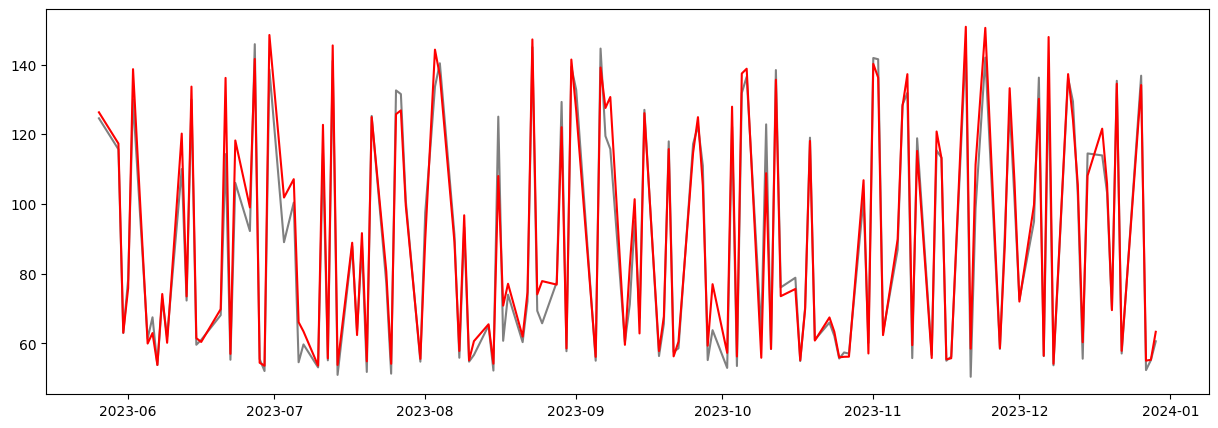

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
df_time = df.index[-len(y_test):]
plt.plot(df_time,y_test,color='gray',label='price')
plt.plot(df_time,y_pred,color='red',label='predict')
plt.show()

In [ ]:
# 计算残差
y_e = y_pred[:,0]-y_test
plt.figure(figsize=(15, 5))
df_time = df.index[-len(y_test):]
plt.plot(df_time,y_e,color='gray',label='price')
plt.show()

In [ ]:
# 对残差纯随机性检验
import numpy as np
import statsmodels.api as sm

data = y_e
# 进行 LBQ 检验，设置 lags 参数为需要检验的自相关阶数
lags = 10  # 选择检验的最大自相关阶数
lbq_test = sm.stats.acorr_ljungbox(data, lags=lags)
print(lbq_test)

# lb_stat 越小，残差自相关性越弱
# p 大于 0.05 才支持 纯随机 假设

# TimeMachine

In [ ]:
import os
os.chdir("/content")
!git clone https://github.com/Atik-Ahamed/TimeMachine.git

Cloning into 'TimeMachine'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 36 (delta 7), reused 32 (delta 6), pack-reused 0
Receiving objects: 100% (36/36), 233.51 KiB | 8.34 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [ ]:
new_dir = "/content/TimeMachine/TimeMachine_supervised"
os.chdir(new_dir)
!pwd

/content/TimeMachine/TimeMachine_supervised


In [ ]:
!pip install -r requirements.txt

In [ ]:
# !wget https://s3.amazonaws.com/data.h2o.ai/h2o-open-tour/2016-nyc/weather.csv

In [ ]:
import pandas as pd

# 指定CSV文件的路径
file_path = '/content/drive/MyDrive/iTransformer_datasets/weather/weather.csv'

# 使用pandas的read_csv函数读取CSV文件
df = pd.read_csv(file_path)

# 显示前几行数据，以检查是否正确读取
print(df.head())

                  date  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  2020-01-01 00:10:00   1008.89      0.71    273.18        -1.33    86.1   
1  2020-01-01 00:20:00   1008.76      0.75    273.22        -1.44    85.2   
2  2020-01-01 00:30:00   1008.66      0.73    273.21        -1.48    85.1   
3  2020-01-01 00:40:00   1008.64      0.37    272.86        -1.64    86.3   
4  2020-01-01 00:50:00   1008.61      0.33    272.82        -1.50    87.4   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  ...  wv (m/s)  \
0          6.43          5.54          0.89       3.42  ...      1.02   
1          6.45          5.49          0.95       3.39  ...      0.43   
2          6.44          5.48          0.96       3.39  ...      0.61   
3          6.27          5.41          0.86       3.35  ...      1.11   
4          6.26          5.47          0.79       3.38  ...      0.49   

   max. wv (m/s)  wd (deg)  rain (mm)  raining (s)  SWDR (W/m�)  \
0           1.60     224.3     

In [ ]:
!pwd

/content/TimeMachine/TimeMachine_supervised


In [ ]:
!sh /content/drive/MyDrive/Colab_Notebooks/weather2.sh

In [ ]:
import torch
if torch.cuda.is_available():
    print('GPU is available!')
else:
    print('GPU is not available.')

GPU is not available.


In [ ]:
!lscpu | grep "CPU"

CPU op-mode(s):                     32-bit, 64-bit
CPU(s):                             2
On-line CPU(s) list:                0,1
Model name:                         Intel(R) Xeon(R) CPU @ 2.20GHz
CPU family:                         6
NUMA node0 CPU(s):                  0,1


In [ ]:
!free -g

               total        used        free      shared  buff/cache   available
Mem:              12           1           7           0           4          11
Swap:              0           0           0


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# Simba

# S-Mamba